In [1]:
import numpy as np
import pandas as pd
import csv
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/infonas/blossom/pbansal/dataset/nyc_taxi/yellow_tripdata_2019-01.csv')
lookup = pd.read_csv('/mnt/infonas/blossom/pbansal/dataset/nyc_taxi/taxi+_zone_lookup.csv')
zone_lookup = dict({})
borough_to_code = {"Brooklyn":0,"Manhattan":1,"Queens":2,"Bronx":3,"Unknown":4,"EWR":5,"Staten Island":6}
for x in lookup.iterrows():
    zone_lookup[x[1]['LocationID']] = borough_to_code[x[1]['Borough']]

In [2]:
data = df[['tpep_pickup_datetime','PULocationID','DOLocationID','passenger_count']]
data['discrete_time'] = 0
def foo(x):
    date_time = pd.to_datetime(x['tpep_pickup_datetime'])
    return (((date_time.year-2019)*12 + (date_time.month-1))*31 + (date_time.day-1))#*24 + date_time.hour
data['discrete_time'] = data.apply(lambda x : foo(x),axis=1)
# data['DOZone'] = data.apply(lambda x : zone_lookup[x['DOLocationID']],axis=1)
# data['PUZone'] = data.apply(lambda x : zone_lookup[x['PULocationID']],axis=1)

/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
removed_zones = [84,103,104,110,176,199,204]
data_19 = data.loc[data['discrete_time'] >= 0].loc[data['discrete_time'] <= 30][['discrete_time','PULocationID','DOLocationID','passenger_count']]
data_19 = data_19.groupby(["discrete_time","PULocationID","DOLocationID"],as_index=False).sum()
data_19 = data_19.loc[~(data_19['PULocationID'].isin(removed_zones))]
data_19 = data_19.loc[~(data_19['DOLocationID'].isin(removed_zones))]

In [4]:
out_array = np.zeros((31,266,266)).astype(np.float)
for x in data_19.iterrows():
    out_array[int(x[1]['discrete_time'])][int(x[1]['PULocationID'])][int(x[1]['DOLocationID'])] = x[1]['passenger_count']

In [6]:
non_zero_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_examples)
np.save('dataset/nyc_taxi_test_non_zero_examples.npy',non_zero_examples[:int(non_zero_examples.shape[0]/3)])
np.save('dataset/nyc_taxi_train_non_zero_examples.npy',non_zero_examples[int(non_zero_examples.shape[0]/3):])
num_points = int(31*266*266)
all_examples = np.zeros((num_points,3))
id_ = 0
for i in range(31):
    for j in range(266):
        for k in range(266):
            all_examples[id_,0] = i
            all_examples[id_,1] = j
            all_examples[id_,2] = k
            id_ += 1
np.save('dataset/nyc_taxi_all_examples.npy',all_examples)
np.save('dataset/nyc_taxi_complete',out_array)

In [25]:
np.unique(data_19[["PULocationID","DOLocationID"]].loc[data_19['passenger_count'] != 0].to_numpy(),axis=0).shape

(32060, 2)

In [146]:
out_array_sub = out_array - np.mean(out_array,axis=0)[None,:,:]
print(out_array.shape)
row_sums = np.sqrt(np.maximum(np.multiply(out_array_sub,out_array_sub),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
print (row_sums.shape)
norm_out_array = out_array_sub / row_sums
norm_out_array.shape
np.save('dataset/nyc_taxi_norm_mean_numpy_complete',norm_out_array)
np.save('dataset/nyc_taxi_unnorm_numpy',out_array)

(31, 266, 266)
(1, 266, 266)


In [68]:
# row_sums = np.sqrt(np.maximum(np.multiply(out_array,out_array),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
# norm_out_array = out_array / row_sums
# norm_out_array.shape
# np.save('dataset/nyc_taxi_norm_noshift_numpy_complete',norm_out_array)

In [6]:
row_sums = np.std(out_array,axis=0,keepdims=True)
row_sums[row_sums == 0] = 1
norm_out_array = out_array / row_sums
norm_out_array.shape
np.save('dataset/nyc_taxi_norm_noshift_numpy_complete',norm_out_array)

In [10]:
f = open('dataset/nyc_taxi_norm_mean_csv_complete.csv','w')
f.write('time,PUZone,DOZone,Measure\n')
for i in range(norm_out_array.shape[0]):
    for j in range(norm_out_array.shape[1]):    
        for k in range(norm_out_array.shape[2]):
            f.write('%d,%d,%d,%f\n'%(i,j,k,norm_out_array[i][j][k]))

In [84]:
# num_points = int(27*266*266)
# all_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(2,29):
#     for j in range(266):
#         for k in range(266):
#             all_examples[id_,0] = i
#             all_examples[id_,1] = j
#             all_examples[id_,2] = k
#             id_ += 1
# np.random.shuffle(all_examples)
# test_size = int(all_examples.shape[0]/3)
# np.save('dataset/nyc_taxi_test_examples.npy',all_examples[:test_size])
# np.save('dataset/nyc_taxi_train_examples.npy',all_examples[test_size:])
# #outliers_ = np.concatenate((np.random.randint(2,5,(num_points,1)),np.random.randint(0,60,(num_points,1)),np.random.randint(0,84,(num_points,1))),1)
# num_points = int(26*266*266)
# no20_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(2,28):
#     for j in range(266):
#         for k in range(266):
#             if (i >= 20):
#                 no20_examples[id_,0] = i+1
#             else : 
#                 no20_examples[id_,0] = i                
#             no20_examples[id_,1] = j
#             no20_examples[id_,2] = k
#             id_ += 1
            
# num_points = int(1*266*266)
# all_20_examples = np.zeros((num_points,3))
# id_ = 0
# for i in range(20,21):
#     for j in range(266):
#         for k in range(266):
#             all_20_examples[id_,0] = i                
#             all_20_examples[id_,1] = j
#             all_20_examples[id_,2] = k
#             id_ += 1
# np.random.shuffle(all_20_examples)
# np.random.shuffle(no20_examples)
# #test_size = int(no20_examples.shape[0]/3)
# np.save('dataset/nyc_taxi_test_all_20_examples.npy',all_20_examples)
# np.save('dataset/nyc_taxi_train_all_no20_examples.npy',no20_examples)


In [7]:
non_zero_non_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] != 20].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_non_20_examples)
np.random.shuffle(non_zero_20_examples)
np.random.shuffle(non_zero_examples)
np.save('dataset/nyc_taxi_test_non_zero_examples.npy',non_zero_examples[:int(non_zero_examples.shape[0]/3)])
np.save('dataset/nyc_taxi_train_non_zero_examples.npy',non_zero_examples[int(non_zero_examples.shape[0]/3):])
np.save('dataset/nyc_taxi_test_non_zero_20_examples.npy',non_zero_20_examples)
np.save('dataset/nyc_taxi_train_non_zero_no20_examples.npy',non_zero_non_20_examples)

In [8]:
non_zero_remove2zones_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] > 1)].loc[(data_19['PULocationID'] != 138)&(data_19['DOLocationID'] != 100)].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_2zones_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] > 1)].loc[(data_19['PULocationID'] == 138)&(data_19['DOLocationID'] == 100)].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_remove2zones_examples)
np.random.shuffle(non_zero_2zones_examples)
np.save('dataset/nyc_taxi_test_non_zero_2zones_examples.npy',non_zero_2zones_examples)
np.save('dataset/nyc_taxi_train_non_zero_2zones_examples.npy',non_zero_remove2zones_examples)

In [9]:
non_zero_zonetime_train_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[(data_19['discrete_time'] < 29) & (data_19['discrete_time'] != 20) & (data_19['discrete_time'] > 1)].loc[data_19['DOLocationID'] != 138].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_zonetime_test_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['DOLocationID'] == 138].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_zonetime_train_examples)
np.random.shuffle(non_zero_zonetime_test_examples)
np.save('dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy',non_zero_zonetime_test_examples)
np.save('dataset/nyc_taxi_train_non_zero_zonetime_100%_examples.npy',non_zero_zonetime_train_examples)
np.save('dataset/nyc_taxi_test_non_zero_zonetime_50%_examples.npy',non_zero_zonetime_test_examples[:int(non_zero_zonetime_test_examples.shape[0]/2)])
np.save('dataset/nyc_taxi_train_non_zero_zonetime_50%_examples.npy',np.concatenate([non_zero_zonetime_train_examples,non_zero_zonetime_test_examples[int(non_zero_zonetime_test_examples.shape[0]/2):]],axis=0))


In [15]:
np.random.seed(42)

non_zero_non_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] > 1].loc[data_19['discrete_time'] != 20].loc[data_19['discrete_time'] < 29].loc[data_19['passenger_count'] != 0].to_numpy()
non_zero_20_examples = data_19[["discrete_time","PULocationID","DOLocationID"]].loc[data_19['discrete_time'] == 20].loc[data_19['passenger_count'] != 0].to_numpy()
np.random.shuffle(non_zero_non_20_examples)
np.random.shuffle(non_zero_20_examples)
size_=100
our_outlier_set = non_zero_non_20_examples[:size_]
our_non_outlier_set = non_zero_20_examples[:size_]
our_train_set = non_zero_non_20_examples[size_:]
np.save('dataset/nyc_taxi_train_our_examples.npy',our_train_set[size_:])
np.save('dataset/nyc_taxi_test_our_outlier_examples.npy',our_outlier_set)
np.save('dataset/nyc_taxi_test_our_inlier_examples.npy',our_non_outlier_set)
np.save('dataset/nyc_taxi_test_our_truly_inlier_examples.npy',our_train_set[:size_])

out_array_sub = out_array - np.mean(out_array,axis=0)[None,:,:]
row_sums = np.sqrt(np.maximum(np.multiply(out_array_sub,out_array_sub),1e-20).sum(axis=0)[None,:,:]/out_array.shape[0])
norm_out_array = out_array_sub / row_sums
np.save('dataset/nyc_taxi_norm_mean_numpy_complete.npy',norm_out_array)

for i in range(non_zero_20_examples.shape[0]):
    norm_out_array[non_zero_20_examples[i][0],non_zero_20_examples[i][1],non_zero_20_examples[i][2]] += 3
for i in range(100):
    norm_out_array[non_zero_non_20_examples[i][0],non_zero_non_20_examples[i][1],non_zero_non_20_examples[i][2]] += 3
np.save('dataset/nyc_taxi_norm_mean_numpy_our.npy',norm_out_array)

In [70]:
######### Generate outlier validation set ##################
test_set = np.load('dataset/nyc_taxi_norm_meadian_numpy_test.npy')
#print (test_set.shape)
num_points = 1000
#45,266,7
outliers_ = np.concatenate((np.random.randint(2,43,(num_points,1)),np.random.randint(0,266,(num_points,1)),np.random.randint(0,7,(num_points,1))),1)
for x in outliers_ :
    test_set[x[0],x[1],x[2]] += 3
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_our.npy',test_set)
np.save('dataset/nyc_taxi_norm_meadian_numpy_test_modified_org_rvae.npy',test_set[2:43])
outliers_ = np.unique(outliers_,axis=0)
print (outliers_.shape)
outliers_ = outliers_.tolist()
# plt.scatter(test_set[1],np.zeros(test_set[1].shape))
# np.where(test_set[1]>5.5)

(995, 3)


In [70]:
from helper import NN, Dataset_
device = torch.device('cuda:1')
loss = torch.nn.L1Loss()
batch_size = 128
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_138_modified.npy','dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
#test_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_2zones_examples.npy')

test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,drop_last = False)
model = NN().to(device)
epoch = 11
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/nyc_checkpoints/checkpoint_%d'%epoch))
pred_ = []
loss_ = 0
for x,y,index in test_loader :
    with torch.no_grad():
        x = x.to(device)
        y_pred = model(x)
        y = y.to(device)
        loss_ += loss(y,y_pred).data*x.shape[0]
        for i in range(x.shape[0]):
            y_ = y[i].data.cpu().numpy() 
            pre_ = y_pred[i].data.cpu().numpy()
            pred_.append([y_,pre_])
#             if (abs(y_-pre_)>3):
#                 outliers.append(((index[0][i],index[1][i],index[2][i]),(y_,pre_)))
loss_ = (loss_/int(len(test_set)))
print (loss_)
pred_ = np.array(pred_)

loading dataset
tensor(1.3778, device='cuda:1')


In [73]:
from ConditionalPredictor.helper import Dataset_,NN

import os
device = torch.device('cuda:1')
batch_size = 64
pred_cond_pred = []
def test_ ():
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_all_20_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_examples.npy')
    val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_138_modified.npy','dataset/nyc_taxi_test_non_zero_zonetime_100%_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_20_modified.npy','dataset/nyc_taxi_test_non_zero_20_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
    #val_set = Dataset_('dataset/nyc_taxi_norm_meadian_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_2zones_examples.npy')

    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = NN().to(device)
    loss = torch.nn.L1Loss()
    epoch = 99
    model.load_state_dict(torch.load(os.path.join('/mnt/blossom/more/pbansal/nyc_checkpoints_cond_pred/','checkpoint_%d'%epoch)))
    loss_ = 0
    for x,y,_ in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred = model(x)
            y = y.to(device)
            loss_ += loss(y,y_pred).data*x.shape[0]
            for i in range(x.shape[0]):
                y_ = y[i].data.cpu().numpy() 
                pre_ = y_pred[i].data.cpu().numpy()
                pred_cond_pred.append([y_,pre_])
    loss_ = loss_/int(len(val_set))
    return loss_
print (test_()) 
pred_cond_pred = np.array(pred_cond_pred)

loading dataset
tensor(3.6148, device='cuda:1')


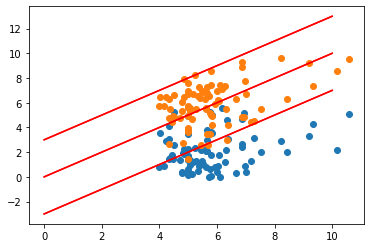

In [74]:
def plot(pred_):
    plt.scatter(pred_[:,0],pred_[:,1])#,alpha=0.2,marker='.')
#     plt.plot([-6,6],[-6,6],c='r')
#     plt.plot([-6,6],[-3,9],c='r')
#     plt.plot([-6,6],[-9,3],c='r')
    plt.plot([0,10],[0,10],c='r')
    plt.plot([0,10],[3,13],c='r')
    plt.plot([0,10],[-3,7],c='r')
plot(pred_cond_pred[:,:])
plot(pred_[:,:])

In [1]:
def test_ (model,val_set):
    device = torch.device('cuda:1')
    batch_size = 64
    preds = []
    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = model.to(device)
    loss_ = 0
    for x,y,index in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred,var = model(x)
            y = y.to(device)
            pred = ((y_pred-y)**2)/var + var
            loss_ +=  pred.mean().data*x.shape[0]
            pred = torch.exp(-0.5*pred).data
            for i in range(x.shape[0]):
                preds.append(((int(index[0][i]),int(index[1][i]),int(index[2][i])),float(pred[i]),float(var[i]),float(y_pred[i]),x[i].cpu()))
    loss_ = loss_/int(len(val_set))
    return loss_,np.array(preds)

In [5]:
import helper
import importlib
importlib.reload(helper)
######## Contextual Analysis ####################

# val_set1 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_our.npy','dataset/nyc_taxi_test_our_outlier_examples.npy')
# val_set2 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_our.npy','dataset/nyc_taxi_test_our_inlier_examples.npy')
# val_set3 = Dataset_('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_our_truly_inlier_examples.npy')
val_set3 = helper.Dataset_('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
epoch = 33
model = helper.NN()
model.load_state_dict(torch.load('/mnt/infonas/blossom/pbansal/nyc_checkpoints/checkpoint_%d'%epoch))

#  t_,outlier_scores = test_(model,val_set1)
# _,inlier_scores = test_(model,val_set2)
_,truly_inlier_scores = test_(model,val_set3)

loading dataset


/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [10]:
from ConditionalPredictor.helper import Dataset_ as CondDataset
from ConditionalPredictor.helper import NN as CondNN
from helper import NN, Dataset_

######## CondPred Analysis ####################

# val_set1 = CondDataset('dataset/nyc_taxi_norm_mean_numpy_our.npy','dataset/nyc_taxi_test_our_outlier_examples.npy')
# val_set2 = CondDataset('dataset/nyc_taxi_norm_mean_numpy_our.npy','dataset/nyc_taxi_test_our_inlier_examples.npy')
val_set3 = CondDataset('dataset/nyc_taxi_norm_noshift_numpy_complete.npy','dataset/nyc_taxi_test_non_zero_examples.npy')
epoch = 10
model = CondNN()
model.load_state_dict(torch.load('/mnt/infonas/blossom/pbansal/nyc_checkpoints_cond_pred/checkpoint_%d'%epoch))

# _,cond_outlier_scores = test_(model,val_set1)
# _,cond_inlier_scores = test_(model,val_set2)
# _,cond_truly_inlier_scores = test_(model,val_set3)

loading dataset


<All keys matched successfully>

In [12]:
torch.save(model.feat_embedd[1],'saved_embeddings/pulocation.pt')
torch.save(model.feat_embedd[2],'saved_embeddings/dolocation.pt')
# for param in model.feat_embedd.parameters():
#     print (param.shape)

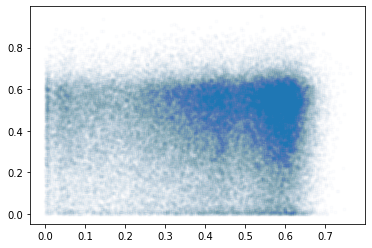

In [16]:
plt.scatter(x=truly_inlier_scores[:,1],y=cond_truly_inlier_scores[:,1],alpha=0.01,marker='.')
# plt.hist(truly_inlier_scores[:,1],alpha=0.5)
# plt.hist(cond_truly_inlier_scores[:,1],alpha=0.5)

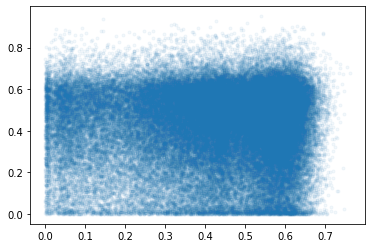

In [153]:
plt.scatter(x=truly_inlier_scores[:,1],y=cond_truly_inlier_scores[:,1],alpha=0.05,marker='.')

In [17]:
temp_cond = cond_truly_inlier_scores[np.argsort(cond_truly_inlier_scores[:,1])]
temp_context = truly_inlier_scores[np.argsort(truly_inlier_scores[:,1])]

In [80]:
complete = np.load('dataset/nyc_taxi_norm_noshift_numpy_complete.npy')

In [7]:
[(14,145,145),(20, 36, 112),(20, 148, 138)]

In [30]:
for i,x in enumerate(temp_context):
    if (x[0] == (15, 186, 72)):
        print (i)

8


In [143]:
print ("Cond Rank, Context Rank")

# for i1 in range(20):
#     for i2,x in enumerate(temp_context):
#         if (x[0] == temp_cond[i1][0]):
#             print (i1,i2)

for i1 in range(20):
    for i2,x in enumerate(temp_cond):
        if (x[0] == temp_context[i1][0]):
            print (i2,i1)
        

Cond Rank, Context Rank
2 0
12 1
6 2
15 3
4 4
230 5
7 6
55 7
0 8
174 9
1607 10
104 11
21 12
20 13
47 14
76 15
249 16
805 17
415 18
3656 19


In [117]:
#### Examples of interest #######

#1 Good, Index : (28, 168, 261), CondRank : 5, ContextRank : 2242
#2 Bad, Index : , CondRank : 8, ContextRank : 6343
#3 Bad, Index : , CondRank : 10, ContextRank : 4180
#4 Good, Index : , CondRank : 17, ContextRank : 17314

#1 Index : , CondRank : 1607, ContextRank : 10
#2 Index : , CondRank : 3656, ContextRank : 19

In [141]:
x,i = temp_cond,1607
#x,i = temp_context,10
visualise(x[i],complete)

Index is :  (5, 95, 236) , Inlier Prob : 0.012237
Pred Value is : 2.177258,Deviation is : 1.120347
True Value : 6, Normalised Value : 5.111742
Input Features : 
tensor([  5.,  95., 236.])
Time Series : 
[0.         1.7039141  1.7039141  0.85195705 0.85195705 5.1117423
 1.7039141  0.         0.85195705 0.         0.         0.
 0.85195705 0.         0.85195705 0.85195705 0.85195705 0.85195705
 0.         1.7039141  0.         0.         0.85195705 0.85195705
 0.85195705 0.         1.7039141  0.         0.         0.
 0.85195705]
PULocation fixed as : 95


,time-2,time-1,time,time+1,time+2
7,1.0,1.0,2.0,1.0,0.0
10,1.0,1.0,0.0,0.0,0.0
13,1.0,0.0,0.0,0.0,1.0
16,0.0,0.0,1.0,0.0,0.0
17,0.0,0.0,0.0,0.0,1.0
18,1.0,0.0,0.0,0.0,0.0
28,6.0,0.0,4.0,0.0,4.0
36,0.0,0.0,0.0,0.0,1.0
39,0.0,0.0,0.0,1.0,1.0
41,0.0,0.0,0.0,1.0,0.0


DOLocation fixed as : 236


,time-2,time-1,time,time+1,time+2
4,5.0,14.0,6.0,9.0,1.0
7,5.0,4.0,3.0,0.0,3.0
10,0.0,3.0,1.0,0.0,0.0
12,6.0,0.0,0.0,0.0,0.0
13,21.0,12.0,8.0,23.0,15.0
24,53.0,67.0,32.0,53.0,58.0
25,1.0,0.0,0.0,0.0,0.0
28,0.0,1.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,1.0
32,1.0,0.0,0.0,0.0,0.0


In [104]:
def visualise(in_,norm_out_array):
    index = in_[0]
    print ("Index is : ",index,", Inlier Prob : %f"%(in_[1]))
    print ("Pred Value is : %f,Deviation is : %f"%(in_[3],in_[2]))
    true_value = int(data_19.loc[(data_19["discrete_time"] == index[0]) & (data_19["PULocationID"] == index[1]) & (data_19["DOLocationID"] == index[2])]['passenger_count'])
    time_series_value = norm_out_array[:,index[1],index[2]]
    normalised_value = time_series_value[index[0]]
    print ("True Value : %d, Normalised Value : %f"%(true_value,normalised_value))
    print ("Input Features : ")
    print (in_[4])
    print ("Time Series : ")
    print (time_series_value)
    temp_array = np.zeros((5,266+266))
    temp_data = data_19.loc[(data_19["discrete_time"] >= index[0]-2) & (data_19["discrete_time"] <= index[0]+2) & (data_19["PULocationID"] == index[1])]
    for x in temp_data.iterrows():
        temp_array[int(x[1]['discrete_time'])-index[0]+2][int(x[1]['DOLocationID'])] = x[1]['passenger_count']    

    temp_data = data_19.loc[(data_19["discrete_time"] >= index[0]-2) & (data_19["discrete_time"] <= index[0]+2) & (data_19["DOLocationID"] == index[2])]
    for x in temp_data.iterrows():
        temp_array[int(x[1]['discrete_time'])-index[0]+2][266+int(x[1]['PULocationID'])] = x[1]['passenger_count']    
    
    pd.set_option('display.max_rows', None)
    print ("PULocation fixed as : %d"%index[1])
    temp_temp_data = pd.DataFrame(data=temp_array[:,:266].transpose(),index=np.arange(266),columns=['time-2','time-1','time','time+1','time+2'])
    display(temp_temp_data.loc[(temp_temp_data['time-2']!=0)|(temp_temp_data['time-1']!=0)|(temp_temp_data['time']!=0)|(temp_temp_data['time+1']!=0)|(temp_temp_data['time+2']!=0)])
    print ("DOLocation fixed as : %d"%index[2])
    temp_temp_data = pd.DataFrame(data=temp_array[:,266:].transpose(),index=np.arange(266),columns=['time-2','time-1','time','time+1','time+2'])
    display(temp_temp_data.loc[(temp_temp_data['time-2']!=0)|(temp_temp_data['time-1']!=0)|(temp_temp_data['time']!=0)|(temp_temp_data['time+1']!=0)|(temp_temp_data['time+2']!=0)])
    return

In [66]:
# from sklearn.metrics import roc_auc_score,roc_curve,auc,brier_score_loss,accuracy_score
# import matplotlib.pyplot as plt

# y_pred = np.concatenate([cond_outlier_scores[:,1],cond_inlier_scores[:,1],cond_truly_inlier_scores[:,1]])
# y_true = np.concatenate([np.zeros(cond_outlier_scores[:,1].shape),np.ones(cond_inlier_scores[:,1].shape),np.ones(cond_truly_inlier_scores[:,1].shape)])
# fpr, tpr, threshold = roc_curve(y_true,y_pred)
# print(auc(fpr,tpr))
# plt.plot(fpr,tpr)

# y_pred = np.concatenate([outlier_scores[:,1],inlier_scores[:,1],truly_inlier_scores[:,1]])
# y_true = np.concatenate([np.zeros(outlier_scores[:,1].shape),np.ones(inlier_scores[:,1].shape),np.ones(truly_inlier_scores[:,1].shape)])
# fpr, tpr, threshold = roc_curve(y_true,y_pred)
# print(auc(fpr,tpr))
# plt.plot(fpr,tpr)

In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
tensor1 = torch.load('saved_embeddings/pulocation.pt').weight.data
tensor1 /= tensor1.norm(dim=1,keepdim=True)
a = tensor1.numpy()
a = euclidean_distances(a)
tau = 1
a = np.exp(-tau*(a**2))

In [55]:
indices = np.argsort(a)[:,-10:-1]
values = np.sort(a)[:,-10:-1]

In [61]:
# print (indices.shape)
# print (values.shape)
# print (values)
temp = [2,3,4,5,3]
#values[temp]
values.size

2394

In [62]:
num_points = int(31*266*266)
all_examples = np.zeros((num_points,3))
id_ = 0
for i in range(31):
    for j in range(266):
        for k in range(266):
            all_examples[id_,0] = i
            all_examples[id_,1] = j
            all_examples[id_,2] = k
            id_ += 1
np.save('dataset/nyc_taxi_all_examples.npy',all_examples)